In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor
from rasa.gumnn.MultidimensionnalMonotonicNN import SlowDMonotonicNN

In [5]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

In [6]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_numeric, X_categorical1):
        X = torch.cat([X_numeric, self.emb1(X_categorical1).squeeze()], 1)
        return F.relu(self.fc1(X))

In [7]:
class MonotonicNet(nn.Module):
    def __init__(self, embedding_net, dim_monotonic):
        super().__init__()
        self.embedding_net = embedding_net()
        self.umnn = SlowDMonotonicNN(dim_monotonic, 16, [128, 128, 32], 1, 300)

    def forward(self, X_monotonic, X_numeric, X_categorical1):
        h = self.embedding_net(X_numeric, X_categorical1)
        return self.umnn(X_monotonic, h)

In [16]:
model = NeuralNetRegressor(MonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           module__embedding_net=EmbeddingNet,
                           module__dim_monotonic=2)

In [17]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_numeric': df[['x4']].values,
           'X_categorical1': df[['x3']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.5068        0.3486  8.2387
      2        0.3490        0.3053  8.3856
      3        0.3097        0.2944  8.2483
      4        0.2999        0.2882  8.1917
      5        0.2967        0.2886  8.1589
      6        0.2950        0.2890  8.2638
      7        0.2933        0.2868  8.2728
      8        0.2918        0.2855  8.4460
      9        0.2896        0.2833  8.4443
     10        0.2865        0.2799  8.2580
     11        0.2814        0.2736  8.1662
     12        0.2726        0.2602  8.2632
     13        0.2560        0.2366  8.1694
     14        0.2285        0.2039  8.2166
     15        0.1933        0.1742  8.2483
     16        0.1620        0.1683  8.2969
     17        0.1436        0.1912  8.2728
     18        0.1583        0.1689  8.3500
     19        0.1512        0.1685  8.4061
     20        0.1351        0.1492  8.2259
     21        0.1284        0.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MonotonicNet(
    (embedding_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
            (6): Linear(in_features=32, out_features=1, bias=True)
            (7): ELU(alpha=1.0)
          )
        )
        (net): Sequential(
          (0): Linear(in_features=16, out_features=128, bias=True)
          (1): ReLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
          (3): ReLU()
          (4): Linear(in_features=128, out_feat

In [18]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [19]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_numeric': dfc[['x4']].values,
                       'X_categorical1': dfc[['x3']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

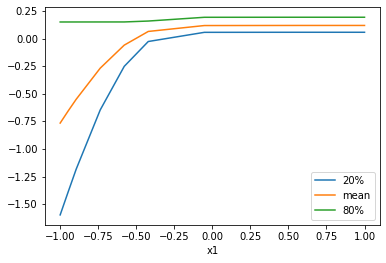

In [20]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()